In [1]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import lstm, time 
import numpy as np
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Using TensorFlow backend.


In [2]:
dataset = read_csv('verdillo.csv', header=0, index_col=0)
values = dataset.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
print(values)


[[  5.28537000e+05   6.60000000e+01   5.46022841e-01]
 [  5.02627000e+05   5.70000000e+01   4.78221960e-01]
 [  1.98093000e+05   3.80000000e+01   1.54769652e+00]
 [  9.20300000e+04   3.60000000e+01   1.51302835e+00]
 [  2.01849000e+05   3.90000000e+01   2.67901019e+00]
 [  4.68211000e+05   4.40000000e+01   3.07956265e+00]
 [  5.56083000e+05   7.80000000e+01   2.29148396e+00]
 [  1.28738600e+06   1.07000000e+02   1.17100765e+00]
 [  4.36327000e+05   1.18000000e+02   1.09039818e+00]
 [  4.50525000e+05   1.15000000e+02   7.54990195e-01]
 [  2.38511000e+05   9.50000000e+01   6.08370582e-01]
 [  2.50040000e+05   7.70000000e+01   7.68892100e-01]
 [  2.44178000e+05   5.80000000e+01   7.07643131e-01]
 [  3.91003000e+05   4.00000000e+01   1.31635097e+00]
 [  4.22160000e+05   2.50000000e+01   2.42552952e+00]
 [  3.31256000e+05   1.40000000e+01   3.16312083e+00]
 [  5.65022000e+05   4.30000000e+01   2.81570330e+00]
 [  3.30223000e+05   5.10000000e+01   3.55553988e+00]
 [  9.63541000e+05   9.00000

In [3]:
# ensure all data is float
values = values.astype('float32')


In [4]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True) 

In [5]:
print(values.shape)

(132, 3)


In [16]:
# split into train and test sets
values = reframed.values
n_train_hours = 132-24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print(values.shape,train.shape,test.shape)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))



(131, 4) (108, 4) (23, 4)


In [17]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Activation('tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=35, batch_size=10,validation_data=(test_X, test_y),shuffle=False)



Train on 108 samples, validate on 23 samples
Epoch 1/35
108/108 [==============================] - 0s - loss: 0.1898 - val_loss: 0.1903
Epoch 2/35
108/108 [==============================] - 0s - loss: 0.1617 - val_loss: 0.1509
Epoch 3/35
108/108 [==============================] - 0s - loss: 0.1491 - val_loss: 0.1281
Epoch 4/35
108/108 [==============================] - 0s - loss: 0.1430 - val_loss: 0.1162
Epoch 5/35
108/108 [==============================] - 0s - loss: 0.1398 - val_loss: 0.1114
Epoch 6/35
108/108 [==============================] - 0s - loss: 0.1357 - val_loss: 0.1099
Epoch 7/35
108/108 [==============================] - 0s - loss: 0.1342 - val_loss: 0.1082
Epoch 8/35
108/108 [==============================] - 0s - loss: 0.1339 - val_loss: 0.1076
Epoch 9/35
108/108 [==============================] - 0s - loss: 0.1317 - val_loss: 0.1063
Epoch 10/35
108/108 [==============================] - 0s - loss: 0.1290 - val_loss: 0.1052
Epoch 11/35
108/108 [=======================

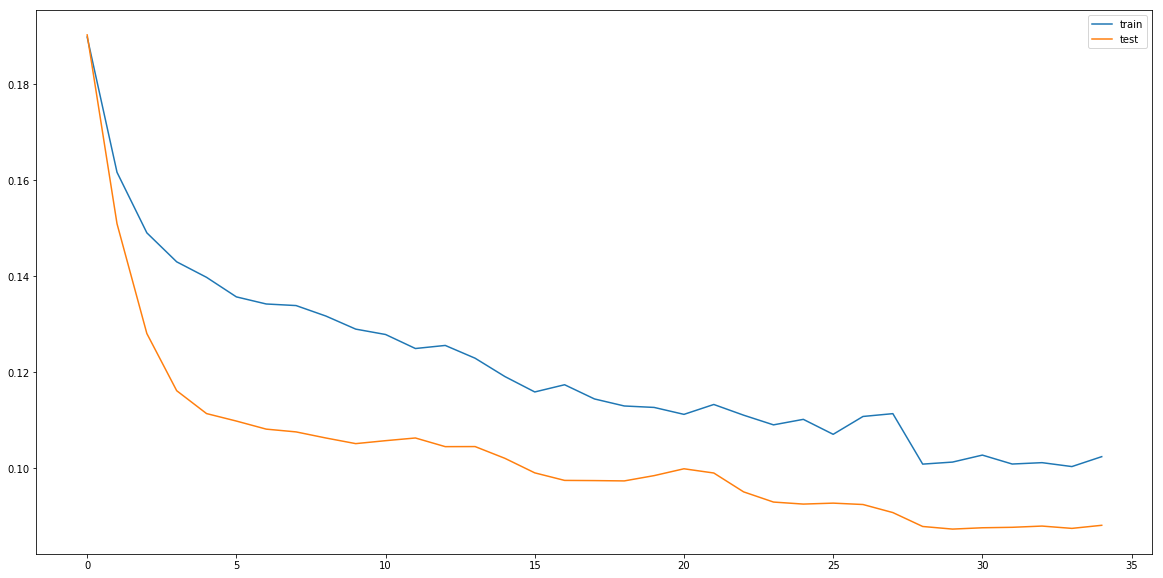

In [18]:
pyplot.figure(figsize=(20,10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [19]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [20]:
print(test_X.shape)
print(yhat.shape)

(23, 3)
(23, 1)


In [21]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[1:,0]


In [22]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:22,0]

In [23]:
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
r=pearsonr(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test R %.3f' %r[0])

Test RMSE: 122022.086
Test R 0.992


In [24]:
pyplot.figure(figsize=(20,10))
pyplot.plot(inv_y, label='y')
pyplot.plot(inv_yhat, label='yhat')
pyplot.legend()

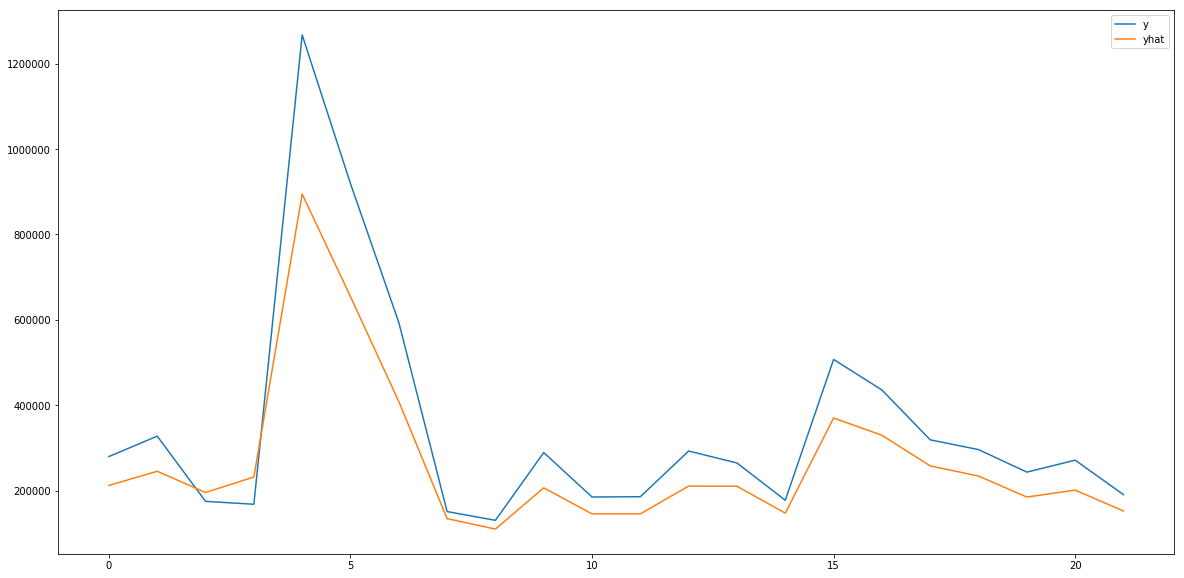

In [25]:
pyplot.show()